# HopperBulletEnv with Twin Delayed DDPG (TD3)

### Paper: https://arxiv.org/abs/1802.09477


### 1. Start the Environment and Agent 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pybullet_envs
import pybullet_envs.bullet as bul

import torch.nn.functional as F

import gym
import os

import time
from TwinDelayed import Actor, Critic, ReplayBuffer, TD3
from collections import deque
import itertools as it


current_dir=D:\Users\user\Anaconda2_02Aug2019\envs\ml2\lib\site-packages\pybullet_envs\bullet
device:  cpu


In [2]:
start_timestep=1e4

std_noise=0.02

env = gym.make('HopperBulletEnv-v0')

# Set seeds
seed = 12345
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])
threshold = env.spec.reward_threshold

print('start_dim: ', state_dim, ', action_dim: ', action_dim)
print('n max_action: ', max_action, ', threshold: ', threshold, ', std_noise: ', std_noise)

agent = TD3(state_dim, action_dim, max_action)


start_dim:  15 , action_dim:  3
n max_action:  1.0 , threshold:  2500.0 , std_noise:  0.02


### 2. Traning the agent

In [3]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, filename, directory):
    torch.save(agent.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(agent.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_t.pth' % (directory, filename))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_t.pth' % (directory, filename))   

In [4]:
# Twin Delayed Deep Deterministic (TD3) policy gradient algorithm
def twin_ddd_train(n_episodes=15000, save_every=10, print_env=10):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    time_start = time.time()                    # Init start time
    replay_buf = ReplayBuffer()                 # Init ReplayBuffer
    
    timestep_after_last_save = 0
    total_timesteps = 0
    
    low = env.action_space.low
    high = env.action_space.high
    
    print('Low in action space: ', low, ', High: ', high, ', Action_dim: ', action_dim)
            
    for i_episode in range(1, n_episodes+1):
        
        timestep = 0
        total_reward = 0
        
        # Reset environment
        state = env.reset()
        done = False
        
        while True:
            
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                if std_noise != 0: 
                    shift_action = np.random.normal(0, std_noise, size=action_dim)
                    action = (action + shift_action).clip(low, high)
            
            # Perform action
            new_state, reward, done, _ = env.step(action) 
            done_bool = 0 if timestep + 1 == env._max_episode_steps else float(done)
            total_reward += reward                          # full episode reward

            # Store every timestep in replay buffer
            replay_buf.add((state, new_state, action, reward, done_bool))
            state = new_state

            timestep += 1     
            total_timesteps += 1
            timestep_after_last_save += 1

            if done:                                       # done ?
                break                                      # save score

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        max_score = np.max(scores_deque)

        # train_by_episode(time_start, i_episode) 
        s = (int)(time.time() - time_start)
        if i_episode % print_env == 0 or (len(scores_deque) == 100 and avg_score > threshold):
            print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Max.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i_episode, total_timesteps, timestep, \
                        total_reward, avg_score, max_score, s//3600, s%3600//60, s%60))     

        agent.train(replay_buf, timestep)

        # Save episode if more than save_every=5000 timesteps
        if timestep_after_last_save >= save_every and i_episode > 0:

            timestep_after_last_save %= save_every            
            save(agent, 'chpnt_interm', 'dir_chk_002')  
        
        if len(scores_deque) == 100 and avg_score >= threshold:
            print('Environment solved with Average Score: ',  avg_score )
            break 

    return scores_array, avg_scores_array

scores, avg_scores = twin_ddd_train()

Low in action space:  [-1. -1. -1.] , High:  [1. 1. 1.] , Action_dim:  3
Ep. 10, Timestep 118,  Ep.Timesteps 10, Score: 20.26, Avg.Score: 21.03, Max.Score: 25.77, Time: 00:00:05 
Ep. 20, Timestep 238,  Ep.Timesteps 11, Score: 19.57, Avg.Score: 20.25, Max.Score: 26.70, Time: 00:00:11 
Ep. 30, Timestep 345,  Ep.Timesteps 15, Score: 18.58, Avg.Score: 20.02, Max.Score: 26.70, Time: 00:00:15 
Ep. 40, Timestep 469,  Ep.Timesteps 8, Score: 19.57, Avg.Score: 20.03, Max.Score: 26.70, Time: 00:00:19 
Ep. 50, Timestep 599,  Ep.Timesteps 16, Score: 23.34, Avg.Score: 20.01, Max.Score: 26.70, Time: 00:00:24 
Ep. 60, Timestep 708,  Ep.Timesteps 20, Score: 24.28, Avg.Score: 19.86, Max.Score: 26.70, Time: 00:00:29 
Ep. 70, Timestep 817,  Ep.Timesteps 7, Score: 18.65, Avg.Score: 19.93, Max.Score: 26.70, Time: 00:00:34 
Ep. 80, Timestep 964,  Ep.Timesteps 20, Score: 22.03, Avg.Score: 20.17, Max.Score: 28.56, Time: 00:00:43 
Ep. 90, Timestep 1078,  Ep.Timesteps 11, Score: 19.33, Avg.Score: 20.03, Max.Scor

Ep. 760, Timestep 8978,  Ep.Timesteps 18, Score: 23.16, Avg.Score: 19.58, Max.Score: 29.76, Time: 00:07:54 
Ep. 770, Timestep 9104,  Ep.Timesteps 7, Score: 20.92, Avg.Score: 19.62, Max.Score: 29.76, Time: 00:08:02 
Ep. 780, Timestep 9211,  Ep.Timesteps 8, Score: 21.54, Avg.Score: 19.64, Max.Score: 29.76, Time: 00:08:09 
Ep. 790, Timestep 9361,  Ep.Timesteps 22, Score: 26.45, Avg.Score: 19.89, Max.Score: 29.76, Time: 00:08:17 
Ep. 800, Timestep 9488,  Ep.Timesteps 8, Score: 21.27, Avg.Score: 20.04, Max.Score: 29.76, Time: 00:08:22 
Ep. 810, Timestep 9627,  Ep.Timesteps 14, Score: 22.65, Avg.Score: 20.14, Max.Score: 37.90, Time: 00:08:28 
Ep. 820, Timestep 9778,  Ep.Timesteps 8, Score: 20.16, Avg.Score: 20.14, Max.Score: 37.90, Time: 00:08:36 
Ep. 830, Timestep 9906,  Ep.Timesteps 8, Score: 20.52, Avg.Score: 20.30, Max.Score: 37.90, Time: 00:08:44 
Ep. 840, Timestep 10008,  Ep.Timesteps 4, Score: 12.58, Avg.Score: 20.19, Max.Score: 37.90, Time: 00:08:50 
Ep. 850, Timestep 10048,  Ep.Time

Ep. 1510, Timestep 12688,  Ep.Timesteps 4, Score: 12.54, Avg.Score: 12.35, Max.Score: 13.10, Time: 00:11:15 
Ep. 1520, Timestep 12728,  Ep.Timesteps 4, Score: 12.18, Avg.Score: 12.35, Max.Score: 13.10, Time: 00:11:17 
Ep. 1530, Timestep 12768,  Ep.Timesteps 4, Score: 12.05, Avg.Score: 12.32, Max.Score: 13.07, Time: 00:11:19 
Ep. 1540, Timestep 12808,  Ep.Timesteps 4, Score: 12.87, Avg.Score: 12.32, Max.Score: 13.07, Time: 00:11:21 
Ep. 1550, Timestep 12848,  Ep.Timesteps 4, Score: 12.04, Avg.Score: 12.28, Max.Score: 13.07, Time: 00:11:23 
Ep. 1560, Timestep 12888,  Ep.Timesteps 4, Score: 12.81, Avg.Score: 12.29, Max.Score: 13.07, Time: 00:11:24 
Ep. 1570, Timestep 12928,  Ep.Timesteps 4, Score: 12.83, Avg.Score: 12.36, Max.Score: 13.07, Time: 00:11:25 
Ep. 1580, Timestep 12968,  Ep.Timesteps 4, Score: 12.66, Avg.Score: 12.37, Max.Score: 13.07, Time: 00:11:26 
Ep. 1590, Timestep 13008,  Ep.Timesteps 4, Score: 12.80, Avg.Score: 12.36, Max.Score: 13.07, Time: 00:11:28 
Ep. 1600, Timestep 

Ep. 2260, Timestep 20104,  Ep.Timesteps 55, Score: 100.49, Avg.Score: 68.30, Max.Score: 125.18, Time: 00:18:25 
Ep. 2270, Timestep 20647,  Ep.Timesteps 62, Score: 89.79, Avg.Score: 74.62, Max.Score: 125.18, Time: 00:18:54 
Ep. 2280, Timestep 21172,  Ep.Timesteps 55, Score: 75.90, Avg.Score: 78.20, Max.Score: 125.18, Time: 00:19:23 
Ep. 2290, Timestep 21685,  Ep.Timesteps 54, Score: 76.15, Avg.Score: 78.65, Max.Score: 125.18, Time: 00:19:51 
Ep. 2300, Timestep 22195,  Ep.Timesteps 48, Score: 60.08, Avg.Score: 78.23, Max.Score: 125.18, Time: 00:20:21 
Ep. 2310, Timestep 22706,  Ep.Timesteps 48, Score: 65.09, Avg.Score: 78.84, Max.Score: 125.18, Time: 00:20:48 
Ep. 2320, Timestep 23200,  Ep.Timesteps 55, Score: 92.72, Avg.Score: 79.60, Max.Score: 125.18, Time: 00:21:15 
Ep. 2330, Timestep 23711,  Ep.Timesteps 44, Score: 79.88, Avg.Score: 79.65, Max.Score: 105.30, Time: 00:21:45 
Ep. 2340, Timestep 24230,  Ep.Timesteps 51, Score: 98.43, Avg.Score: 81.65, Max.Score: 116.22, Time: 00:22:10 


Ep. 2960, Timestep 450534,  Ep.Timesteps 1000, Score: 2427.13, Avg.Score: 2250.93, Max.Score: 2567.41, Time: 07:05:40 
Ep. 2970, Timestep 458609,  Ep.Timesteps 1000, Score: 2364.24, Avg.Score: 2207.86, Max.Score: 2548.06, Time: 07:09:50 
Ep. 2980, Timestep 468168,  Ep.Timesteps 559, Score: 1388.39, Avg.Score: 2199.64, Max.Score: 2548.06, Time: 07:14:49 
Ep. 2990, Timestep 478168,  Ep.Timesteps 1000, Score: 2450.59, Avg.Score: 2229.05, Max.Score: 2548.06, Time: 07:19:12 
Ep. 3000, Timestep 488168,  Ep.Timesteps 1000, Score: 2436.02, Avg.Score: 2232.79, Max.Score: 2548.06, Time: 07:24:15 
Ep. 3010, Timestep 498168,  Ep.Timesteps 1000, Score: 2547.13, Avg.Score: 2243.20, Max.Score: 2548.06, Time: 07:28:58 
Ep. 3020, Timestep 507386,  Ep.Timesteps 1000, Score: 2383.20, Avg.Score: 2229.71, Max.Score: 2548.06, Time: 07:33:51 
Ep. 3030, Timestep 517386,  Ep.Timesteps 1000, Score: 2496.95, Avg.Score: 2246.97, Max.Score: 2547.13, Time: 07:38:41 
Ep. 3040, Timestep 527386,  Ep.Timesteps 1000, Sc

Ep. 3640, Timestep 1082431,  Ep.Timesteps 1000, Score: 2441.29, Avg.Score: 2312.67, Max.Score: 2574.31, Time: 14:36:51 
Ep. 3650, Timestep 1092431,  Ep.Timesteps 1000, Score: 2493.98, Avg.Score: 2336.79, Max.Score: 2574.31, Time: 14:46:06 
Ep. 3660, Timestep 1098663,  Ep.Timesteps 220, Score: 475.49, Avg.Score: 2240.35, Max.Score: 2574.31, Time: 14:52:47 
Ep. 3670, Timestep 1100765,  Ep.Timesteps 124, Score: 260.91, Avg.Score: 2048.30, Max.Score: 2574.31, Time: 14:54:57 
Ep. 3680, Timestep 1103126,  Ep.Timesteps 149, Score: 323.91, Avg.Score: 1880.45, Max.Score: 2574.31, Time: 14:57:02 
Ep. 3690, Timestep 1105938,  Ep.Timesteps 270, Score: 625.08, Avg.Score: 1739.59, Max.Score: 2574.31, Time: 14:59:39 
Ep. 3700, Timestep 1115389,  Ep.Timesteps 1000, Score: 2355.80, Avg.Score: 1739.78, Max.Score: 2574.31, Time: 15:08:11 
Ep. 3710, Timestep 1125389,  Ep.Timesteps 1000, Score: 2387.61, Avg.Score: 1744.92, Max.Score: 2574.31, Time: 15:16:52 
Ep. 3720, Timestep 1134860,  Ep.Timesteps 1000, 

Ep. 4320, Timestep 1674504,  Ep.Timesteps 1000, Score: 2519.64, Avg.Score: 1798.45, Max.Score: 2630.00, Time: 22:43:42 
Ep. 4330, Timestep 1682755,  Ep.Timesteps 1000, Score: 2619.47, Avg.Score: 1753.56, Max.Score: 2629.71, Time: 22:53:20 
Ep. 4340, Timestep 1690883,  Ep.Timesteps 1000, Score: 2565.93, Avg.Score: 1735.34, Max.Score: 2629.71, Time: 23:02:10 
Ep. 4350, Timestep 1700399,  Ep.Timesteps 1000, Score: 2370.26, Avg.Score: 1721.80, Max.Score: 2629.71, Time: 23:14:36 
Ep. 4360, Timestep 1707878,  Ep.Timesteps 122, Score: 237.94, Avg.Score: 1664.45, Max.Score: 2629.71, Time: 23:25:28 
Ep. 4370, Timestep 1710385,  Ep.Timesteps 55, Score: 90.32, Avg.Score: 1468.39, Max.Score: 2629.71, Time: 23:27:55 
Ep. 4380, Timestep 1715893,  Ep.Timesteps 48, Score: 29.03, Avg.Score: 1370.46, Max.Score: 2629.71, Time: 23:32:57 
Ep. 4390, Timestep 1720453,  Ep.Timesteps 1000, Score: 2530.23, Avg.Score: 1260.47, Max.Score: 2629.71, Time: 23:36:09 
Ep. 4400, Timestep 1726021,  Ep.Timesteps 1000, Sc

Ep. 5000, Timestep 2161581,  Ep.Timesteps 1000, Score: 2523.00, Avg.Score: 2239.47, Max.Score: 2658.13, Time: 30:22:01 
Ep. 5010, Timestep 2171581,  Ep.Timesteps 1000, Score: 2513.63, Avg.Score: 2350.10, Max.Score: 2658.13, Time: 30:33:06 
Ep. 5020, Timestep 2181391,  Ep.Timesteps 810, Score: 2027.05, Avg.Score: 2427.09, Max.Score: 2658.13, Time: 30:43:29 
Ep. 5030, Timestep 2191391,  Ep.Timesteps 1000, Score: 2509.74, Avg.Score: 2433.87, Max.Score: 2658.13, Time: 30:53:20 
Ep. 5040, Timestep 2201391,  Ep.Timesteps 1000, Score: 2423.03, Avg.Score: 2446.28, Max.Score: 2658.13, Time: 31:03:58 
Ep. 5050, Timestep 2211391,  Ep.Timesteps 1000, Score: 2393.46, Avg.Score: 2441.88, Max.Score: 2658.13, Time: 31:13:27 
Ep. 5060, Timestep 2221391,  Ep.Timesteps 1000, Score: 2374.02, Avg.Score: 2431.17, Max.Score: 2658.13, Time: 31:22:34 
Ep. 5070, Timestep 2231391,  Ep.Timesteps 1000, Score: 2378.18, Avg.Score: 2423.25, Max.Score: 2658.13, Time: 31:31:31 
Ep. 5080, Timestep 2241391,  Ep.Timesteps

In [6]:
save(agent, 'chpnt_ts2500', 'dir_chk_002')  

length of scores:  5438 , len of avg_scores:  5438


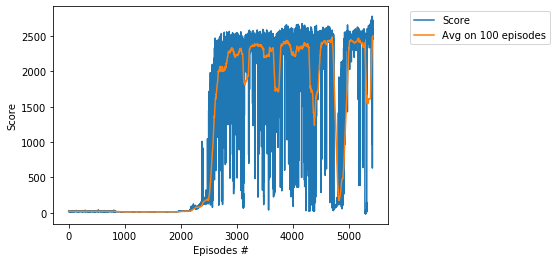

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
from collections import deque
import os

def play(env, agent, n_episodes):
    state = env.reset()
    
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        score = 0
        
        time_start = time.time()
        
        while True:
            action = agent.select_action(np.array(state))
            env.render()
            time.sleep(0.01)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break 

        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))  

play(env=env, agent=agent, n_episodes=7)


Episode 1	Average Score: 2660.82,	Score: 2660.82 	Time: 00:00:18
Episode 2	Average Score: 2652.16,	Score: 2643.50 	Time: 00:00:17
Episode 3	Average Score: 2615.37,	Score: 2541.80 	Time: 00:00:18
Episode 4	Average Score: 2623.42,	Score: 2647.57 	Time: 00:00:17
Episode 5	Average Score: 2627.60,	Score: 2644.33 	Time: 00:00:17
Episode 6	Average Score: 2631.54,	Score: 2651.21 	Time: 00:00:18
Episode 7	Average Score: 2635.73,	Score: 2660.87 	Time: 00:00:17


In [ ]:
env.close()